In [1]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 7.16.1

numpy 1.19.1
pandas 1.1.1
torch 1.4.0
transformers 3.1.0


In [93]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8


In [4]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Examine the data

In [24]:
# https://www.kaggle.com/kazanova/sentiment140
column_names = ["target", "ids", "date", "flag","user","text"]
df = pd.read_csv("data/training.1600000.processed.noemoticon.csv", names=column_names, header=None, encoding="ISO-8859-1")

In [25]:
print(f'\nShape: {df.shape}\n')
df.head()


Shape: (1600000, 6)



,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB



0 is negative, 4 is positive



<AxesSubplot:xlabel='target', ylabel='count'>

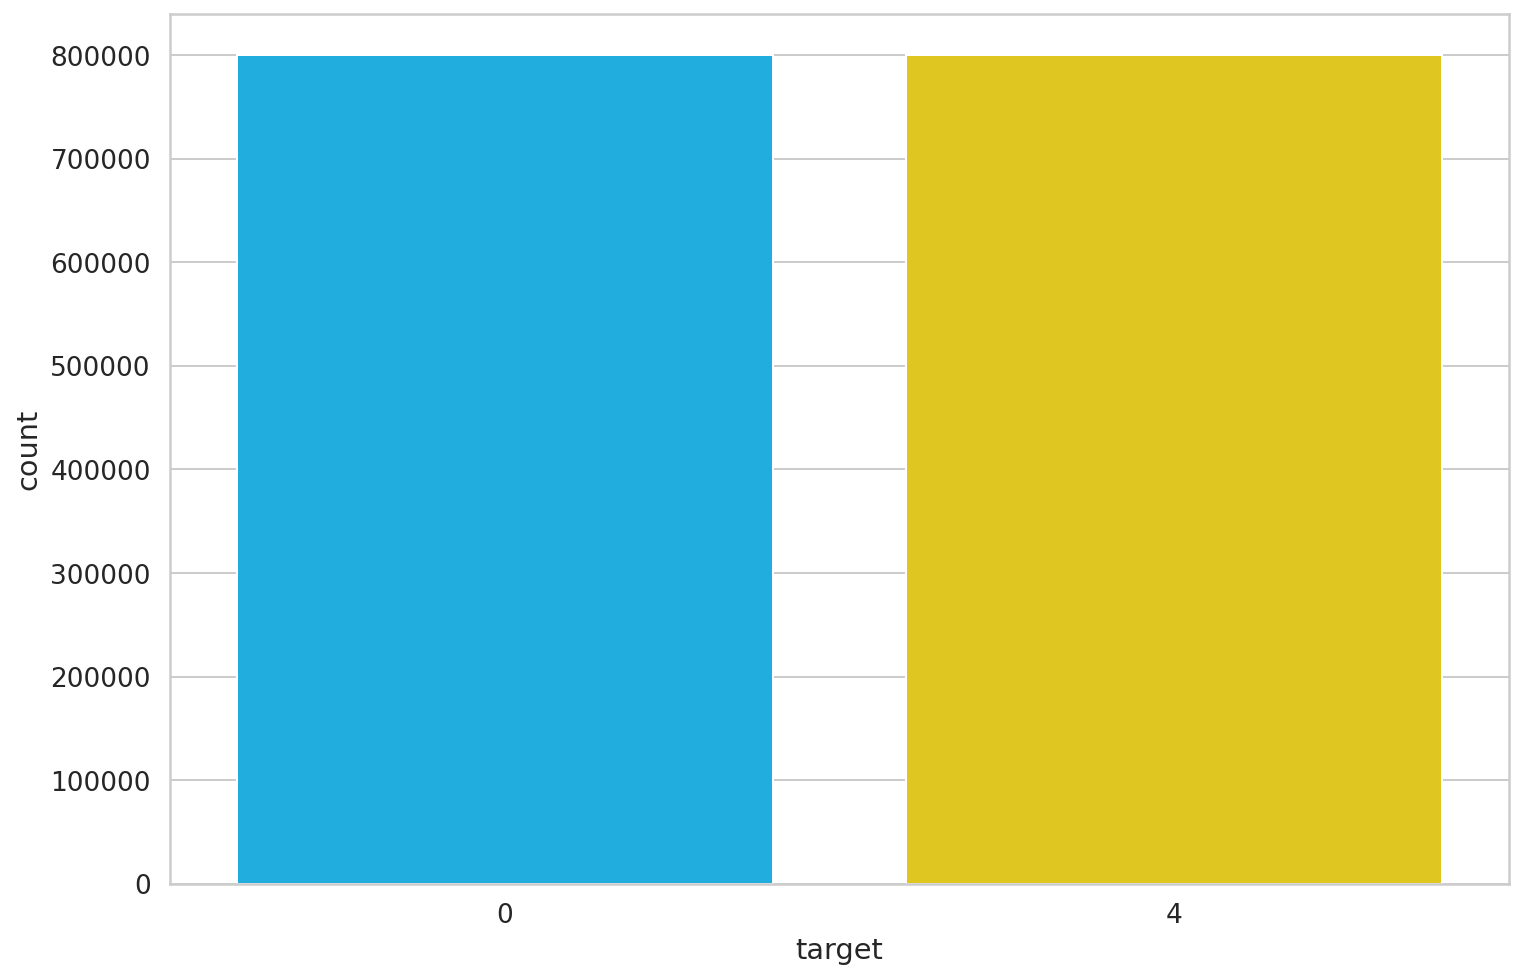

In [31]:
print(f'\n{0} is negative, {4} is positive\n')
sns.countplot(df.target)

In [89]:
class_names = ['negative', 'positive']

In [32]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [33]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

#### Tokenization converts text to tokens for specific model. bert-base-cased model doesn't ignore the case of text, for example

In [34]:
sample_txt = "I wish I could go outside but some jerks aren't wearing masks and prolonging this whole thing"

In [38]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f'Sentence: {sample_txt}\nTokens: {tokens}\nToken IDs: {token_ids}')

Sentence: I wish I could go outside but some jerks aren't wearing masks and prolonging this whole thing
Tokens: ['I', 'wish', 'I', 'could', 'go', 'outside', 'but', 'some', 'jerk', '##s', 'aren', "'", 't', 'wearing', 'masks', 'and', 'pro', '##long', '##ing', 'this', 'whole', 'thing']
Token IDs: [146, 3683, 146, 1180, 1301, 1796, 1133, 1199, 12935, 1116, 4597, 112, 189, 3351, 17944, 1105, 5250, 9851, 1158, 1142, 2006, 1645]


### Some tokens can be added manually to tell BERT what to do 

In [39]:
tokenizer.sep_token, tokenizer.sep_token_id

('[SEP]', 102)

### The [CLS] Token needs to be added to the start of each sentence to do classification

In [40]:
tokenizer.cls_token, tokenizer.cls_token_id

('[CLS]', 101)

### [PAD] is a token for padding

In [41]:
tokenizer.pad_token, tokenizer.pad_token_id

('[PAD]', 0)

### Tokens not in the training set will be encoded using the unknown [UNK] token

In [42]:
tokenizer.unk_token, tokenizer.unk_token_id

('[UNK]', 100)

### the encode_plus() method does all the necessary encoding

In [45]:
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length=32,
    truncation=True,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt'
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [46]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([  101,   146,  3683,   146,  1180,  1301,  1796,  1133,  1199, 12935,
         1116,  4597,   112,   189,  3351, 17944,  1105,  5250,  9851,  1158,
         1142,  2006,  1645,   102,     0,     0,     0,     0,     0,     0,
            0,     0])

In [47]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [48]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'I',
 'wish',
 'I',
 'could',
 'go',
 'outside',
 'but',
 'some',
 'jerk',
 '##s',
 'aren',
 "'",
 't',
 'wearing',
 'masks',
 'and',
 'pro',
 '##long',
 '##ing',
 'this',
 'whole',
 'thing',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

### Choosing sequence length - figure out the size of the sequence which we should set

In [65]:
token_lens = []
for index, txt in df.text.items():
    if (index % 100000) == 0:
        print(f'{index}/{df.text.size}')
    tokens = tokenizer.encode(txt, max_length=280, truncation=True)
    token_lens.append(len(tokens))

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
13

Text(0.5, 0, 'Token Count')

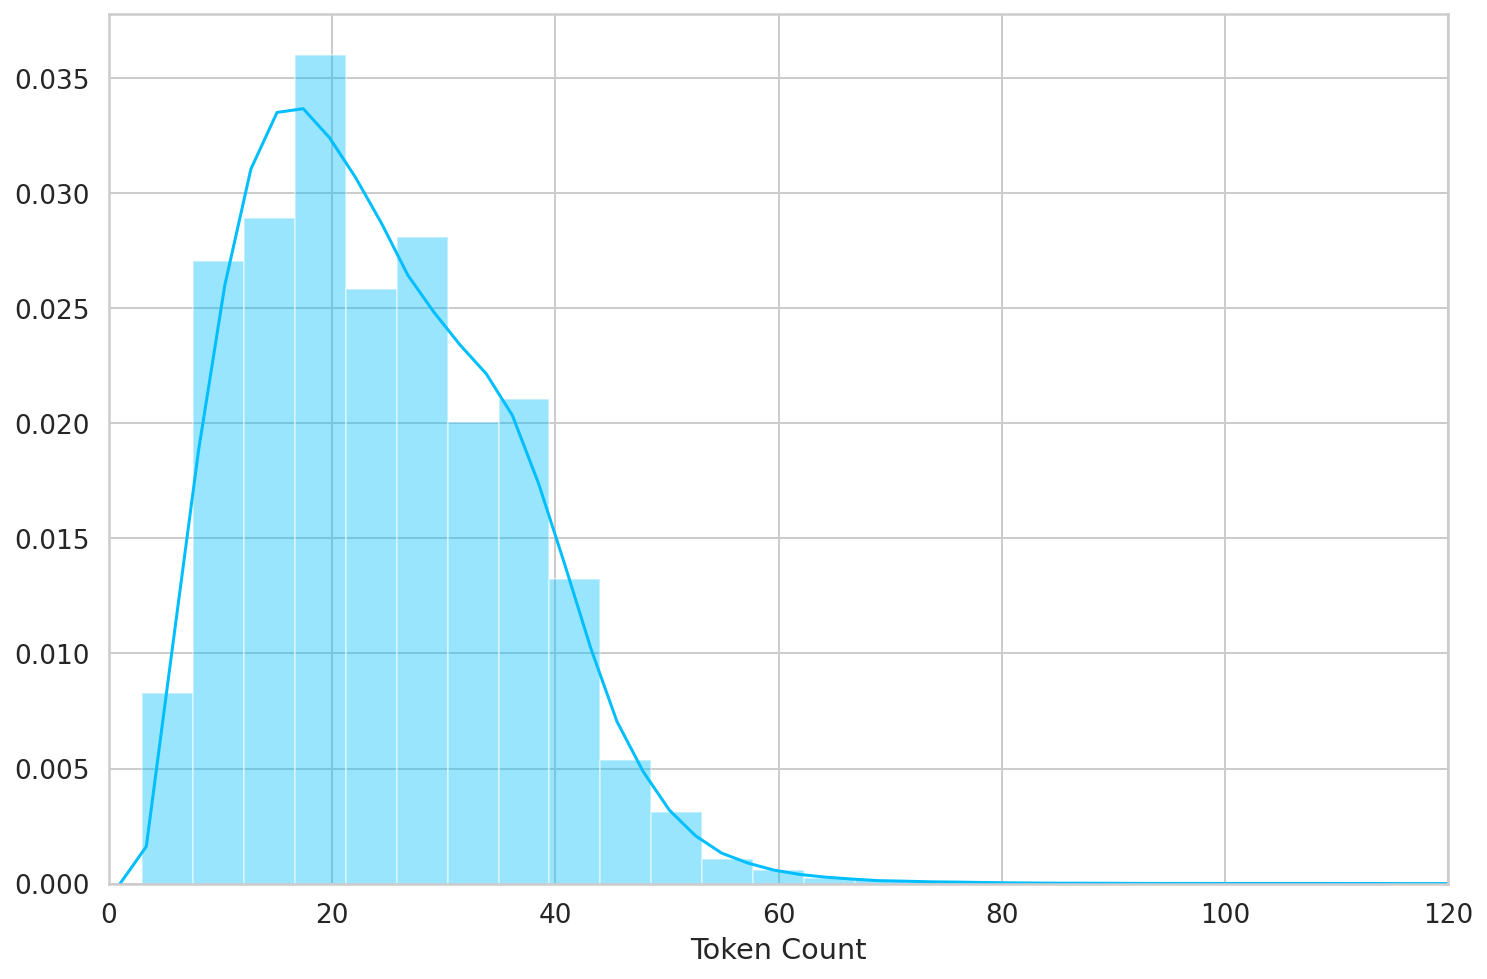

In [68]:
sns.distplot(token_lens)
plt.xlim([0,120])
plt.xlabel('Token Count')

### Twitter posts seem to have a max of about 70 tokens, we'll make the max 70.

In [72]:
MAX_LEN = 70

In [77]:
class TwitterDataset(Dataset):
    def __init__(self, tweets, targets, tokenizer, max_len):
        self.tweets = tweets
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.tweets)
    
    def __getitem__(self, item):
        tweets = str(self.tweets[item])
        target = self.targets[item]
        
        encoding = self.tokenizer.encode_plus(
          tweets,
          add_special_tokens=True,
          max_length=self.max_len,
          truncation = True,
          return_token_type_ids=False,
          padding='max_length',
          return_attention_mask=True,
          return_tensors='pt',
        )
        
        return {
          'tweets_text': tweets,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

### Separate data into train/test/validation sets (90/5/5)

In [70]:
df_train, df_test = train_test_split(
    df,
    test_size=0.1,
    random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
    df_test,
    test_size=0.5,
    random_state=RANDOM_SEED
)

In [71]:
df_train.shape, df_val.shape, df_test.shape

((1440000, 6), (80000, 6), (80000, 6))

### Training data loader

In [78]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = TwitterDataset(
        tweets=df.text.to_numpy(),
        targets=df.target.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )
    
    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=4
    )

BATCH_SIZE=16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


### Check out an example batch:

In [79]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['tweets_text', 'input_ids', 'attention_mask', 'targets'])

In [81]:
print(f"{data['input_ids'].shape}\n{data['attention_mask'].shape}\n{data['targets'].shape}")


torch.Size([16, 70])
torch.Size([16, 70])
torch.Size([16])


## Load up the BERT model!

In [82]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

#### Use the model on the example text

In [83]:
last_hidden_state, pooled_output = bert_model(
    input_ids=encoding['input_ids'],
    attention_mask=encoding['attention_mask']
)

In [84]:
last_hidden_state.shape

torch.Size([1, 32, 768])

In [85]:
bert_model.config.hidden_size

768

In [86]:
pooled_output.shape

torch.Size([1, 768])

In [87]:
class SentimentClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        output = self.drop(pooled_output)
        return self.out(output)

In [90]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [91]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 70])
torch.Size([16, 70])


In [94]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3087, 0.6913],
        [0.2800, 0.7200],
        [0.3630, 0.6370],
        [0.3219, 0.6781],
        [0.3594, 0.6406],
        [0.1778, 0.8222],
        [0.3657, 0.6343],
        [0.2973, 0.7027],
        [0.4108, 0.5892],
        [0.4542, 0.5458],
        [0.3778, 0.6222],
        [0.2055, 0.7945],
        [0.4002, 0.5998],
        [0.3377, 0.6623],
        [0.3104, 0.6896],
        [0.1520, 0.8480]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [95]:
EPOCHS = 10
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
loss_fn = nn.CrossEntropyLoss().to(device)

In [97]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    return correct_predictions.double() / n_examples, np.mean(losses)

In [99]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
    return correct_predictions.double() / n_examples, np.mean(losses)

In [100]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------


RuntimeError: CUDA error: device-side assert triggered